In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist
pynrc.setup_logging('WARNING', verbose=False)

In [3]:
from pynrc.nrc_utils import *

In [4]:
fpix, osamp = (321, 2)
filt = 'F430M'
pupil='WEDGELYOT'
mask='MASKLWB'

In [5]:
bp_k = pynrc.bp_2mass('k')
sp_sci = pynrc.stellar_spectrum('A0V', 7, 'vegamag', bp_k)
sp_ref = pynrc.stellar_spectrum('A0V', 6, 'vegamag', bp_k)


In [9]:
obs = pynrc.obs_hci(sp_sci, sp_ref, 100, verbose=True,
                    filter=filt, pupil=pupil, mask=mask, fov_pix=fpix, oversample=osamp)

Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.


In [12]:
obs.psf_info_bg

{'force': False,
 'fov_pix': 321,
 'jitter': None,
 'offset_r': 0,
 'offset_theta': 0,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits', 0),
 'oversample': 2,
 'save': True,
 'tel_pupil': None}

In [13]:
self = obs

In [30]:
xoff_arcsec_max = 10

xpix = self.det_info['xpix']
xpix_off_asec = np.ceil(xpix * self.pix_scale / 2)

xoff_asec = np.min([xpix_off_asec, xoff_arcsec_max])

# Offset values to create new PSF
del_off = 1
offset_vals = np.arange(-xoff_asec, xoff_asec+del_off, del_off)



In [31]:
offset_vals

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [22]:
psf_list = []
for offset in offset_vals:
    print(offset)
    self.bar_offset = offset
    _, psf = self.gen_psf(return_oversample=True, use_bg_psf=False)
    psf_list.append(psf)


-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10


In [21]:
baroff_orig

1.0431999999999979

In [ ]:
coeff  = psf_coeff(filt, pupil, mask, fov_pix=fpix, oversample=osamp)

In [5]:
cf_resid = wedge_coeff(filt, pupil, mask, fov_pix=fpix, oversample=osamp)

[     pynrc:WARNING] Generating field-dependent coefficients. This may take some time.


In [6]:
# The narrow location (arcsec)
bar_offset = 0
cf_fit = cf_resid.reshape([cf_resid.shape[0], -1])
cf_mod = jl_poly(np.array([bar_offset]), cf_fit).reshape(coeff.shape)
cf_new = coeff + cf_mod

In [7]:
psf    = gen_image_coeff(filt, pupil, mask, coeff=cf_new, fov_pix=fpix, oversample=osamp)

In [8]:
psf0   = gen_image_coeff(filt, pupil, mask, coeff=coeff, fov_pix=fpix, oversample=osamp)

In [9]:
diff = psf0-psf

In [10]:
ind = psf0>0
chi1 = np.sum((diff[ind])**2 / psf0[ind])

print(chi1, chi1 / psf0.sum())

4.8826650308e-06 0.00571674978586


In [29]:
ind = psf>0
chi1 = np.sum((diff[ind])**2 / psf[ind])

print(chi1, chi1 / psf.sum())

1.55220781874e-05 0.0182745205825


In [5]:
nrc = pynrc.NIRCam(filt, pupil, mask, fov_pix=fpix, oversample=osamp)

[     pynrc:WARNING] Generating field-dependent coefficients. This may take some time.


In [17]:
nrc.bar_offset=-8

In [25]:
nrc.wfe_drift = 0

In [19]:
psf0 = nrc.gen_psf()

In [27]:
psf5 = nrc.gen_psf()

In [28]:
np.max(np.abs(psf5-psf0)) / psf0.max()

0.0

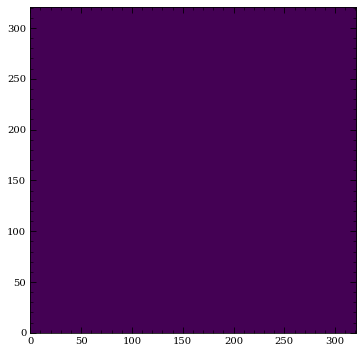

In [29]:
plt.imshow(psf5-psf0)

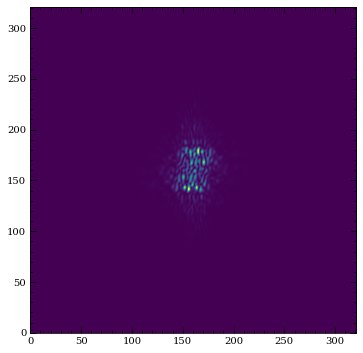

In [7]:
plt.imshow(nrc.gen_psf())

In [28]:
ratio = abs(diff) / psf0
ind = ratio != np.inf
np.nanmax(ratio[ind])

81.830281201726194

In [50]:
force=False
save=True
save_name=None

kwargs = {}
kwargs['force']     = True
kwargs['save']      = False
kwargs['save_name'] = None

kwargs['pupil'] = pupil
kwargs['mask'] = mask

module = kwargs.get('module', 'A')
kwargs['module'] = module

kwargs['fov_pix'] = fpix
kwargs['oversample'] = osamp

# Get filter throughput and create bandpass 
bp = read_filter(filter)
channel = 'SW' if bp.avgwave() < 24000 else 'LW'

# Final filename to save coeff
if save_name is None:
    # Name to save array of oversampled coefficients
    save_dir = conf.PYNRC_PATH + 'psf_coeffs/'
    # Create directory if it doesn't already exist
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    # Final filename to save coeff
    save_name = psf_coeff(filter, return_save_name=True, **kwargs)
    save_name = os.path.splitext(save_name)[0] + '_wedge.npy'


In [51]:
# Cycle through a list of bar offset locations
values = np.arange(-8,8,0.5)
nvals = len(values)

# First is default value
kwargs['include_si_wfe'] = True
cf0 = psf_coeff(filter, bar_offset=0, **kwargs)

cf_offset = []
for val in values:
    print('Bar Offset: {:.1f} arcsec'.format(val))
    kwargs['bar_offset'] = val

    cf = psf_coeff(filter, **kwargs)
    cf_offset.append(cf)


Bar Offset: -8.0 arcsec
Bar Offset: -7.5 arcsec
Bar Offset: -7.0 arcsec
Bar Offset: -6.5 arcsec
Bar Offset: -6.0 arcsec
Bar Offset: -5.5 arcsec
Bar Offset: -5.0 arcsec
Bar Offset: -4.5 arcsec
Bar Offset: -4.0 arcsec
Bar Offset: -3.5 arcsec
Bar Offset: -3.0 arcsec
Bar Offset: -2.5 arcsec
Bar Offset: -2.0 arcsec
Bar Offset: -1.5 arcsec
Bar Offset: -1.0 arcsec
Bar Offset: -0.5 arcsec
Bar Offset: 0.0 arcsec
Bar Offset: 0.5 arcsec
Bar Offset: 1.0 arcsec
Bar Offset: 1.5 arcsec
Bar Offset: 2.0 arcsec
Bar Offset: 2.5 arcsec
Bar Offset: 3.0 arcsec
Bar Offset: 3.5 arcsec
Bar Offset: 4.0 arcsec
Bar Offset: 4.5 arcsec
Bar Offset: 5.0 arcsec
Bar Offset: 5.5 arcsec
Bar Offset: 6.0 arcsec
Bar Offset: 6.5 arcsec
Bar Offset: 7.0 arcsec
Bar Offset: 7.5 arcsec


In [52]:
cf_offset = np.array(cf_offset)

# Get residuals
cf_offset -= cf0

# Fit each pixel with a polynomial and save the coefficient
cf_offset = cf_offset.reshape([nvals, -1])

In [59]:
wedge_cf = jl_poly_fit(values, cf_offset, 4)
wedge_cf = wedge_cf.reshape([-1, cf.shape[0], cf.shape[1], cf.shape[2]])

In [60]:
for i in range(len(cf_offset)):
    cf_real = cf_offset[i].reshape(cf0.shape) + cf0

    psf_real = gen_image_coeff('F430M', pupil, mask, coeff=cf_real, fov_pix=fpix, oversample=osamp)

    bar_offset = values[i]
    cf_fit = wedge_cf.reshape([wedge_cf.shape[0], -1])
    cf_mod = jl_poly(np.array([bar_offset]), cf_fit).reshape(coeff.shape)

    cf_new = cf_mod + cf0
    psf_new   = gen_image_coeff('F430M', pupil, mask, coeff=cf_new, fov_pix=fpix, oversample=osamp)
    
    diff = psf_real - psf_new
    ind = psf_real>0
    chi1 = np.sum((diff[ind])**2 / psf_real[ind])

    print(i, bar_offset, chi1, chi1 / psf_real.sum())

0 -8.0 1.684772402e-05 0.0313168052272
1 -7.5 3.64502217024e-05 0.0683158907255
2 -7.0 9.89680241041e-06 0.0182078938357
3 -6.5 7.61097419151e-06 0.0137053164923
4 -6.0 4.74219514196e-06 0.00823431932635
5 -5.5 2.99606697315e-06 0.00504466505576
6 -5.0 1.7023791285e-06 0.00277072719988
7 -4.5 9.61387175009e-07 0.0015155336546
8 -4.0 6.5135906069e-07 0.000994765785762
9 -3.5 8.32885692247e-07 0.00123385475035
10 -3.0 1.39630847879e-06 0.00200973989718
11 -2.5 2.07813422993e-06 0.00290892095708
12 -2.0 2.67779925868e-06 0.00364991418923
13 -1.5 2.53905953125e-06 0.00337471716422
14 -1.0 2.12132808862e-06 0.0027520680696
15 -0.5 1.44860305762e-06 0.00183576713538
16 0.0 9.13301114731e-07 0.00113144572349
17 0.5 5.17477585064e-07 0.00062675586566
18 1.0 6.75581158102e-07 0.000799686827676
19 1.5 1.19287597181e-06 0.00137873704775
20 2.0 1.81061563796e-06 0.00204048665258
21 2.5 2.36994708643e-06 0.00259651070146
22 3.0 2.71282460809e-06 0.00287900710317
23 3.5 2.90522777378e-06 0.002972862

In [56]:
for i in range(len(cf_offset)):
    cf_real = cf_offset[i].reshape(cf0.shape) + cf0

    psf_real = gen_image_coeff('F430M', pupil, mask, coeff=cf_real, fov_pix=fpix, oversample=osamp)

    bar_offset = values[i]
    cf_fit = wedge_cf.reshape([wedge_cf.shape[0], -1])
    cf_mod = jl_poly(np.array([bar_offset]), cf_fit).reshape(coeff.shape)

    cf_new = cf_mod + cf0
    psf_new   = gen_image_coeff('F430M', pupil, mask, coeff=cf_new, fov_pix=fpix, oversample=osamp)
    
    diff = psf_real - psf_new
    ind = psf_real>0
    chi1 = np.sum((diff[ind])**2 / psf_real[ind])

    print(i, bar_offset, chi1, chi1 / psf_real.sum())

0 -8.0 8.57412127201e-06 0.0159377068114
1 -7.5 3.66435303478e-05 0.0686781944834
2 -7.0 8.86630752411e-06 0.0163120146709
3 -6.5 6.60126391169e-06 0.0118870999799
4 -6.0 4.62789648073e-06 0.00803585181353
5 -5.5 2.06201859239e-06 0.00347194946927
6 -5.0 1.08074505102e-06 0.00175897933596
7 -4.5 1.01690443669e-06 0.00160305123407
8 -4.0 1.18190311177e-06 0.00180502099169
9 -3.5 1.32224257106e-06 0.00195879853934
10 -3.0 1.21344882461e-06 0.00174654566168
11 -2.5 9.21340370635e-07 0.00128966949014
12 -2.0 5.32650624186e-07 0.000726017480516
13 -1.5 2.84828044586e-07 0.000378570915366
14 -1.0 3.94230991129e-07 0.000511448713924
15 -0.5 8.42071371769e-07 0.00106712942639
16 0.0 1.43654842666e-06 0.00177967216694
17 0.5 1.60028188398e-06 0.00193822126107
18 1.0 1.52880283982e-06 0.00180964711413
19 1.5 1.22441094035e-06 0.00141518545518
20 2.0 8.11269316485e-07 0.000914265942053
21 2.5 4.87235360333e-07 0.000533814376901
22 3.0 6.07265480813e-07 0.000644465413488
23 3.5 1.42859168252e-06 0

In [49]:
for i in range(len(cf_offset)):
    cf_real = cf_offset[i].reshape(cf0.shape) + cf0

    psf_real = gen_image_coeff('F430M', pupil, mask, coeff=cf_real, fov_pix=fpix, oversample=osamp)

    bar_offset = values[i]
    cf_fit = wedge_cf.reshape([wedge_cf.shape[0], -1])
    cf_mod = jl_poly(np.array([bar_offset]), cf_fit).reshape(coeff.shape)

    cf_new = cf_mod + cf0
    psf_new   = gen_image_coeff('F430M', pupil, mask, coeff=cf_new, fov_pix=fpix, oversample=osamp)
    
    diff = psf_real - psf_new
    ind = psf_real>0
    chi1 = np.sum((diff[ind])**2 / psf_real[ind])

    print(i, bar_offset, chi1, chi1 / psf_real.sum())

0 -8 1.5688289204e-05 0.0291616301861
1 -7 1.37978538155e-05 0.0253849523326
2 -6 1.29534343324e-05 0.022492266023
3 -5 9.2348934612e-06 0.0150303596142
4 -4 4.90133449385e-06 0.00748539500454
5 -3 1.03818799088e-06 0.00149428858861
6 -2 1.45348987265e-06 0.00198114675433
7 -1 4.07276230816e-06 0.00528372728552
8 0 5.74251727389e-06 0.00711413410845
9 1 4.89836606967e-06 0.00579820614603
10 2 2.33549553429e-06 0.0026320039245
11 3 1.46803403103e-06 0.00155796301406
12 4 1.4462876001e-05 0.0141763103128
13 5 1.88671115228e-05 0.016562910193
14 6 2.48943880222e-05 0.018772709012
15 7 1.43851118481e-05 0.00894891817656


In [64]:
nrc_utils.offset_bar('F300M', 'MASKLWB')

(5.2485999999999979, -90.0)

In [65]:
filts = ["F250M",
"F300M",
"F277W",
"F335M",
"F360M",
"F356W",
"F410M",
"F430M",
"F460M",
"F480M",
"F444W"]

for f in filts:
    print(nrc_utils.offset_bar(f, 'MASKLWB'))

(6.8459999999999983, -90.0)
(5.2485999999999979, -90.0)
(5.0781199999999993, -90.0)
(4.0749999999999984, -90.0)
(3.1947999999999981, -90.0)
(2.4553199999999991, -90.0)
(1.6625999999999992, -90.0)
(1.0431999999999979, -90.0)
(0.097800000000000803, 90.0)
(0.61940000000000128, 90.0)
(0.76788000000000112, 90.0)
